# 🐈 삼성전자 주가 예측하기


이번에는 LSTM을 이용해서 삼성전자 주가를 예측해봅시다!

## 위 코드는 유튜버 테디노트 님의 영상 및 블로그를 참고하여 작성했습니다.

https://www.youtube.com/c/teddynote/featured

https://teddylee777.github.io/tensorflow/lstm-stock-forecast


In [ ]:
#필요한 라이브러리

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

https://finance.yahoo.com/quote/005930.KS?p=005930.KS

Historical Data에 들어가서 기간과 일별, 주간별, 월별로 csv 파일을 다운받을 수 있습니다!

In [ ]:
# 데이터 불러오기
df = pd.read_csv('./005930.KS.csv')

In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4623.466309,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4222.414063,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4252.681152,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4192.144043,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4366.188477,46880000


In [ ]:
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
5664,2022-07-26,60800.0,61900.0,60800.0,61700.0,61700.0,6597211
5665,2022-07-27,61300.0,61900.0,61200.0,61800.0,61800.0,7320997
5666,2022-07-28,62300.0,62600.0,61600.0,61900.0,61900.0,10745302
5667,2022-07-29,62400.0,62600.0,61300.0,61400.0,61400.0,15093120
5668,2022-08-01,61000.0,61700.0,60300.0,61300.0,61300.0,13097910


In [ ]:
# 날짜 데이터를 문자형에서 날짜형으로 변환

df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [ ]:
# 연, 월, 일 추출하기

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4623.466309,74195000,2000,1,4
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4222.414063,74680000,2000,1,5
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4252.681152,54390000,2000,1,6
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4192.144043,40305000,2000,1,7
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4366.188477,46880000,2000,1,10


In [ ]:
df.dtypes # 연, 월, 일 모두 정수형 자료네요!

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
Year                  int64
Month                 int64
Day                   int64
dtype: object

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


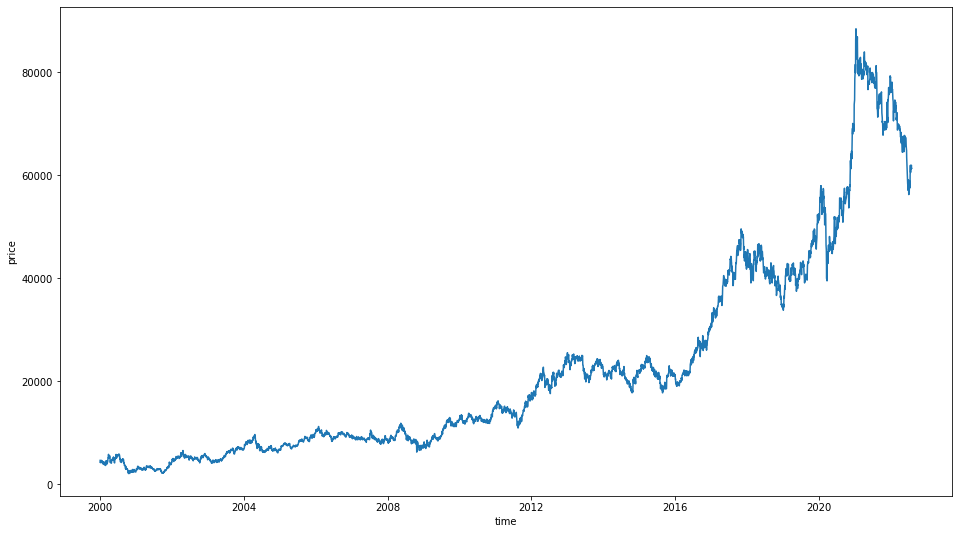

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y = df['Adj Close'], x = df['Date'])
plt.xlabel('time')
plt.ylabel('price')

삼성전자 주식 종가를 도표로 나타내보니, 아주 미쳐 날뛰고 있네요... 허허... 주식을 시작하고 싶으시다면 이 데이터를 제공했던 야후 파이낸스에 들어가서 살펴보시는 건 어떨까요. ㅎㅎ

In [ ]:
# 데이터 전처리

# 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 스케일을 적용할 column을 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.03942571, 0.03562314, 0.03720717, 0.03829161, 0.02963617,
        0.45181622],
       [0.03714676, 0.03509145, 0.03559945, 0.0322873 , 0.02498909,
        0.45476966],
       [0.03657703, 0.03211399, 0.03628847, 0.03274046, 0.0253398 ,
        0.33121213],
       ...,
       [0.68094804, 0.63632497, 0.67960496, 0.67032967, 0.69331149,
        0.06543435],
       [0.68208751, 0.63632497, 0.67615985, 0.66466523, 0.68751788,
        0.09191073],
       [0.66613491, 0.62675457, 0.66467616, 0.66353234, 0.68635916,
        0.07976074]])

스케일이 완료된 column으로 새로운 데이터 프레임을 생성합시다!

In [ ]:
df = pd.DataFrame(scaled, columns = scale_cols)

In [ ]:
# train_test_split

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Adj Close', 1),
                                                    df['Adj Close'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=False)

print([x_train.shape, y_train.shape])
print([x_test.shape, y_test.shape])

[(4535, 5), (4535,)]
[(1134, 5), (1134,)]


In [ ]:
x_train

,Open,High,Low,Close,Volume
0,0.039426,0.035623,0.037207,0.038292,0.451816
1,0.037147,0.035091,0.035599,0.032287,0.454770
2,0.036577,0.032114,0.036288,0.032740,0.331212
3,0.034412,0.030944,0.033762,0.031834,0.245440
4,0.034868,0.032008,0.036288,0.034440,0.285479
...,...,...,...,...,...
4530,0.563582,0.524032,0.563620,0.555681,0.049483
4531,0.561531,0.524670,0.565457,0.559307,0.053375
4532,0.564722,0.524670,0.559026,0.550470,0.069017
4533,0.555834,0.526584,0.558567,0.547525,0.123682


### Tensorflow Dataset을 활용한 시퀀스 데이터셋 구성

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# 하이퍼 파라미터 정의

WINDOW_SIZE = 20
BATCH_SIZE = 32

In [ ]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


### 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss = Huber(), optimizer = optimizer, metrics = ['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor = 'val_loss', patience = 10)

# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only = True, 
                             save_best_only = True, 
                             monitor = 'val_loss', 
                             verbose = 1)

In [ ]:
history = model.fit(train_data, 
                    validation_data = (test_data), 
                    epochs = 50, 
                    callbacks = [checkpoint, earlystopping])

Epoch 1/50
    138/Unknown - 5s 14ms/step - loss: 8.5267e-05 - mse: 1.7053e-04
Epoch 1: val_loss improved from inf to 0.00160, saving model to tmp/ckeckpointer.ckpt
142/142 [==============================] - 6s 22ms/step - loss: 8.4303e-05 - mse: 1.6861e-04 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 2/50
141/142 [============================>.] - ETA: 0s - loss: 2.3272e-05 - mse: 4.6543e-05
Epoch 2: val_loss improved from 0.00160 to 0.00089, saving model to tmp/ckeckpointer.ckpt
142/142 [==============================] - 2s 15ms/step - loss: 2.3279e-05 - mse: 4.6559e-05 - val_loss: 8.8647e-04 - val_mse: 0.0018
Epoch 3/50
138/142 [============================>.] - ETA: 0s - loss: 2.2757e-05 - mse: 4.5514e-05
Epoch 3: val_loss did not improve from 0.00089
142/142 [==============================] - 2s 15ms/step - loss: 2.3325e-05 - mse: 4.6651e-05 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 4/50
141/142 [============================>.] - ETA: 0s - loss: 2.4124e-05 - mse: 4.8248e-05
Epoch 4

In [ ]:
# 저장한 ModelCheckpoint 불러오기
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)
pred.shape

(1114, 1)

### 예측 데이터 시각화

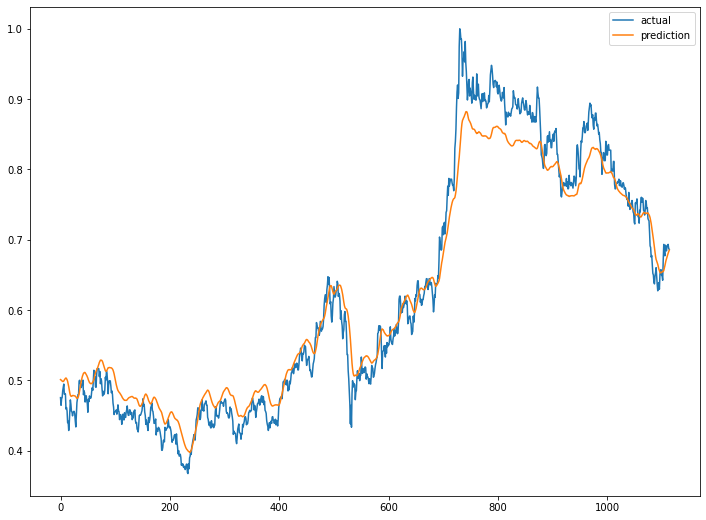

In [ ]:
plt.figure(figsize = (12, 9))
plt.plot(np.asarray(y_test)[20:], label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

위에 시각화 코드중 y_test 데이터에 [20:]으로 슬라이싱을 한 이유는 예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 앞의 20일은 예측하지 않습니다.

따라서, 20번째 index와 비교하면 더욱 정확합니다.